In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
PLT_CELL = 3.5

In [3]:
X = pd.read_csv('../data/Renge/X_renge_d2_80.csv', index_col=0)
E = pd.read_csv('../data/Renge/E_renge_d2_80.csv', index_col=0)

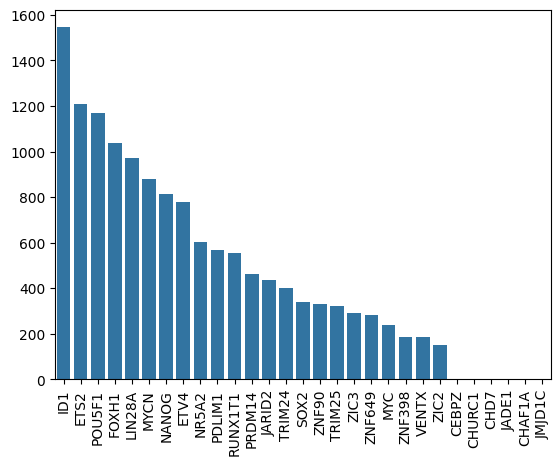

In [4]:
import seaborn as sb
sb.barplot(X.sum(0).sort_values()[::-1][1:30])
plt.xticks(rotation='vertical');

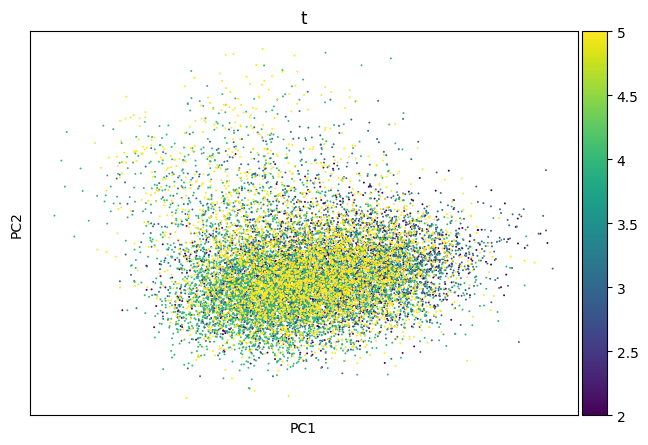

In [5]:
adata_ = ad.AnnData(E)
sc.pp.pca(adata_)
sc.pp.neighbors(adata_)

adata_.obs["t"] = X.t

# no KO
adata_.obs["condition"] = None
adata_.obs.loc[X.index[X.iloc[:, :-1].T.sum(0) == 0], "condition"] = "wt"

idx_ko = X.index[X.iloc[:, :-1].T.sum(0) == 1]
adata_.obs.loc[idx_ko, "condition"] = X.columns[np.argmax(X.loc[idx_ko, :].iloc[:, :-1], -1)]

sc.pl.scatter(adata_, basis = 'pca', color = 't')

In [6]:
import scipy as sp
import gzip
import glob
import pandas as pd
import os

In [ ]:
DATA_PATH = "../data/RENGE_data/"
X_all = []
for fname in np.sort(glob.glob(os.path.join(DATA_PATH, "day*/*.mtx.gz"))):
    print(fname)
    with gzip.open(fname, 'rt') as f:
        X_all.append(sp.io.mmread(f).T)
barcodes_all = []
for fname in np.sort(glob.glob(os.path.join(DATA_PATH, "day*/barcodes.tsv.gz"))):
    print(fname)
    with gzip.open(fname, 'rt') as f:
        barcodes_all.append(pd.read_csv(f, compression='gzip', delimiter='\t', header = None, index_col = 0))
        barcodes_all[-1].index.name = 'barcode'
features_all = []
for fname in np.sort(glob.glob(os.path.join(DATA_PATH, "day*/features.tsv.gz"))):
    print(fname)
    with gzip.open(fname, 'rt') as f:
        features_all.append(pd.read_csv(f, compression='gzip', delimiter='\t', header = None, index_col = 0))
        features_all[-1].columns = ['gene', 'type']
        features_all[-1].index.name = 'ens'

In [7]:
import anndata as ad
import scipy as sp
import scanpy as sc

adata_all = []
ts = [2, 3, 4, 5]
for i in range(len(X_all)):
    adata = ad.AnnData(sp.sparse.csr_matrix(X_all[i]), var = features_all[i], obs = barcodes_all[i])
    adata.obs["t"] = ts[i]
    adata_all.append(adata)

NameError: name 'X_all' is not defined

In [9]:
for t in range(len(ts)):
    A = set(adata_all[t].obs.index)
    B = set(X.index[X.index.str.startswith(f"{t+1}_")].str.split("_").str[1])
    idx = pd.Index(A.intersection(B))
    adata_all[t] = adata_all[t][idx, :]

    _df = X.loc[f'{t+1}_' + adata_all[t].obs.index, :].iloc[:, :-1].copy()
    _df.index = _df.index.str.split('_').str[1]

    _kos = pd.Series(["WT", ] * len(_df.index), index = _df.index)
    _kos[_df.values.sum(-1) > 0] = _df.columns[_df.values.argmax(-1)][_df.values.sum(-1) > 0]
    adata_all[t].obs["ko"] = _kos

/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos
/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos
/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos
/tmp/ipykernel_928420/3140330375.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all[t].obs["ko"] = _kos


In [10]:
adata = ad.concat(adata_all, index_unique="_")

In [11]:
df = adata_all[0].var
not_grna_idx = [x for x in df[df.type != "CRISPR Guide Capture"].index]

adata.var = adata_all[0].var

adata = adata[:, adata.var.loc[not_grna_idx].index]

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)

/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/syz/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [8]:
adata = sc.read_h5ad('../data/Renge/hipsc.h5ad')

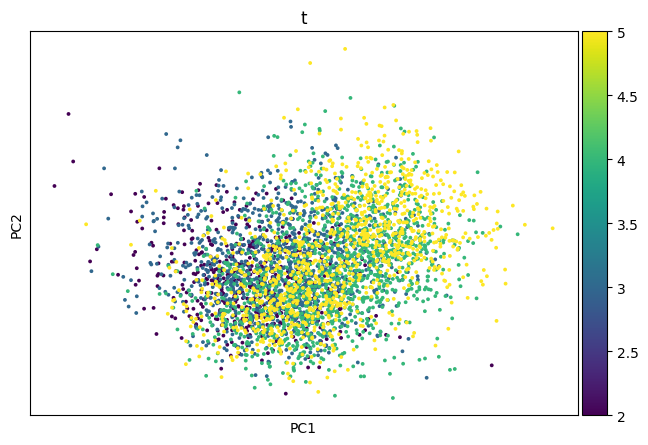

In [9]:
sc.pl.scatter(adata, basis = "pca", color = "t")

In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

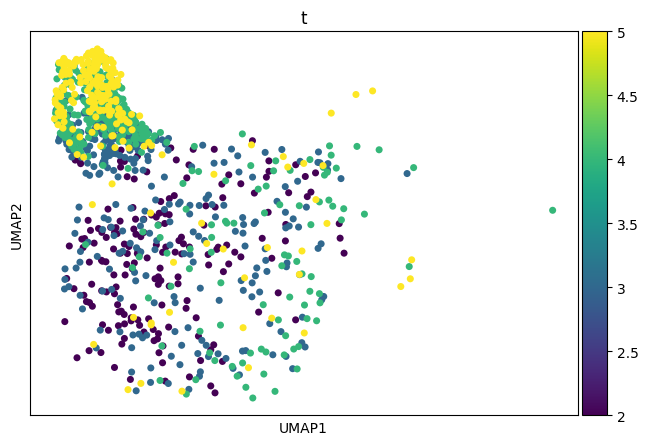

In [10]:
sc.pl.scatter(adata[adata.obs.ko == "POU5F1", :], basis = "umap", color = "t")

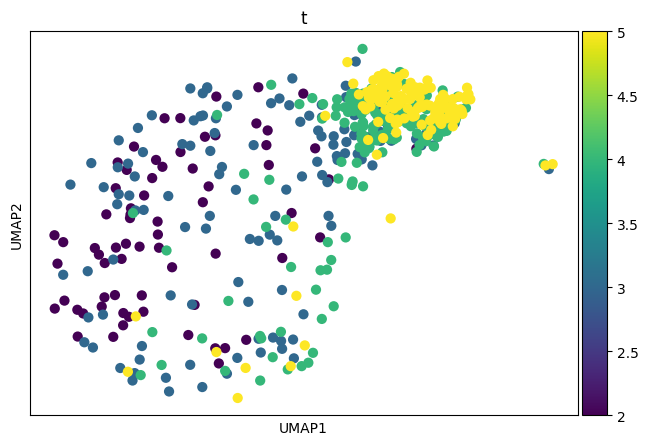

In [11]:
sc.pl.scatter(adata[adata.obs.ko == "RUNX1T1", :], basis = "umap", color = "t")

In [12]:
import dcor
dists_ko = pd.Series({k : dcor.energy_distance(adata.obsm["X_pca"][adata.obs.ko == "WT", :], adata.obsm["X_pca"][adata.obs.ko == k, :]) for k in adata.obs.ko.unique()})

/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


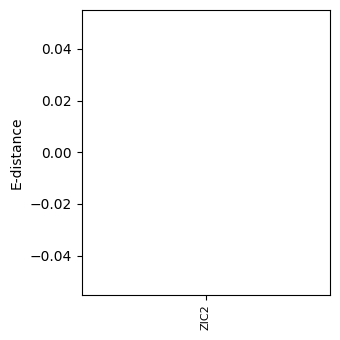

In [12]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.scatterplot(dists_ko.sort_values()[::-1])
plt.ylabel("E-distance")
plt.xticks(rotation = 90, fontsize = 8);
plt.tight_layout()
plt.savefig("scCRISPR_Edists.pdf")

In [13]:
adata_tf = adata.copy()
print(adata_tf.var.gene)
mask = adata_tf.var.gene.isin(E.columns)
adata_tf = adata_tf[:, mask].copy()
adata_tf.var.index = adata_tf.var.gene

ens
ENSG00000120948    TARDBP
ENSG00000125944    HNRNPR
ENSG00000117318       ID3
ENSG00000189266     PNRC2
ENSG00000142684    ZNF593
                    ...  
ENSG00000160113     NR2F6
ENSG00000213988     ZNF90
ENSG00000198093    ZNF649
ENSG00000159086    PAXBP1
ENSG00000157557      ETS2
Name: gene, Length: 103, dtype: category
Categories (103, object): ['ARID4B', 'CEBPZ', 'CENPK', 'CHAF1A', ..., 'ZNF593', 'ZNF649', 'ZNHIT3', 'ZSCAN10']


In [14]:
adata_tf[adata_tf.obs.ko == "POU5F1", :]

View of AnnData object with n_obs × n_vars = 1169 × 103
    obs: 't', 'ko'
    var: 'gene', 'type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
import sys
sys.path.append("../src/models/components")
import importlib
import rf
importlib.reload(rf)
import torch

In [16]:
options = {
    "lr" : 0.1,
    "reg_sinkhorn" : 0.05,
    "reg_A" : 0.5e-3, 
    "reg_A_elastic" : 0.5,
    "iter" : 5_000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam,
    "n_pca_components" : 50
}

In [17]:
_kos =list(dists_ko.sort_values()[::-1][range(8)].index) 
_kos

['ZIC2', 'ZIC3', 'MYC', 'RUNX1T1', 'SOX2', 'NANOG', 'PRDM14', 'POU5F1']

/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/tmp/ipykernel_2140538/235373703.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.scatterplot(x = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 0],


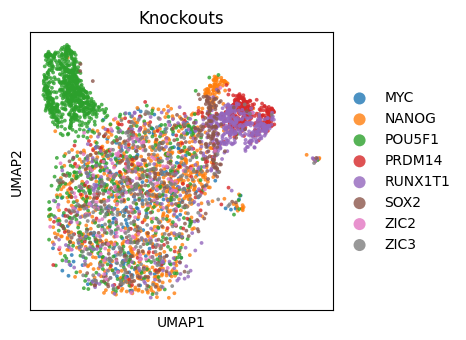

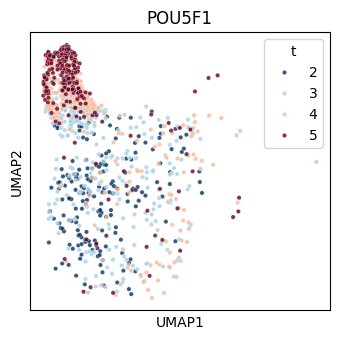

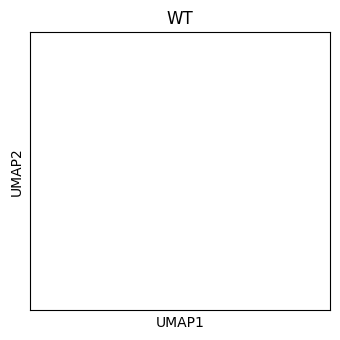

In [18]:
_adata = adata[adata.obs.ko.isin(_kos), :]

fig, ax = plt.subplots(1, 1, figsize=(1.36*PLT_CELL, PLT_CELL))
sc.pl.scatter(_adata, basis = "umap", color = "ko", show = False, ax = ax, alpha = 0.8)
plt.title("Knockouts")
plt.tight_layout()
plt.savefig("scCRISPR_knockouts_umap.pdf")
for g in ["POU5F1", "WT"]:
    fig, ax = plt.subplots(1, 1, figsize=(PLT_CELL, PLT_CELL))
    sb.scatterplot(x = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 0], 
                   y = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 1], 
                   hue = _adata[_adata.obs.ko == g].obs.t, palette="RdBu_r", alpha = 0.8, s = 10)
    plt.title(f"{g}")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()
    plt.savefig(f"scCRISPR_{g}_umap.pdf")

In [19]:
_adatas = []
for k in _kos:
    _adatas.append(adata_tf[adata_tf.obs.ko == k, :].copy())
    _adatas[-1].X = np.asarray(_adatas[-1].X.todense(), dtype = np.float64)
    _adatas[-1].obs.t -= 2
    _adatas[-1].var.index = _adatas[-1].var.gene
if _kos[0] == "WT":
    _kos[0] = None

In [20]:
estim_alt = rf.Estimator(_adatas, _kos, 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"], 
                          n_pca_components = options["n_pca_components"])
estim_alt.fit(print_iter=100, alg = "alternating", update_couplings_iter=500);

/home/noahe162/sf2m-grn-hydra/notebooks/../src/models/components/rf.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad=True, dtype=torch.float64)
/home/noahe162/sf2m-grn-hydra/notebooks/../src/models/components/rf.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.b, requires_grad=True, dtype=torch.float64)


Updating transport plans
iteration 0, loss = 30.376215140425906, L = 30.376215140425906, R = 0.0
iteration 100, loss = 12.617134375196821, L = 12.424236072136, R = 385.7966061216407
iteration 200, loss = 12.296453061021596, L = 12.098119217835453, R = 396.66768637228506
iteration 300, loss = 12.243384615394454, L = 12.039051917013454, R = 408.66539676199886
iteration 400, loss = 12.230919916670839, L = 12.02339299099571, R = 415.05385135025836
iteration 500, loss = 10.957194810610222, L = 10.747639947762595, R = 419.109725695254
iteration 600, loss = 9.90018987901313, L = 9.761494561139628, R = 277.39063574700435
iteration 700, loss = 9.795082548281837, L = 9.647058565073007, R = 296.0479664176607
iteration 800, loss = 9.754010809100057, L = 9.601196599698413, R = 305.62841880328676
iteration 900, loss = 9.733663235668146, L = 9.576612690053997, R = 314.1010912282992
iteration 1000, loss = 9.823127102659365, L = 9.663383500595815, R = 319.4872041271008
iteration 1100, loss = 9.79161422

In [50]:
_adata_wt = []
for k in ["WT", ]:
    _adata_wt.append(adata_tf[adata_tf.obs.ko == k, :].copy())
    _adata_wt[-1].X = np.asarray(_adata_wt[-1].X.todense(), dtype = np.float64)
    _adata_wt[-1].obs.t -= 2
    _adata_wt[-1].var.index = _adata_wt[-1].var.gene
estim_wt = rf.Estimator(_adata_wt, [None, ], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"], 
                           n_pca_components=options["n_pca_components"])
estim_wt.fit(print_iter=100, alg = "alternating", update_couplings_iter=500);

/home/syz/Projects/temporal_perturb/notebooks/../src/rf.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = 27.229519316259413, L = 27.229519316259413, R = 0.0
iteration 100, loss = 9.841119997717508, L = 9.557191857866261, R = 567.8562797024917
iteration 200, loss = 9.506775400871062, L = 9.228416024868384, R = 556.7187520053565
iteration 300, loss = 9.450486129350699, L = 9.163991232502458, R = 572.9897936964836
iteration 400, loss = 9.436101347520705, L = 9.1457015035959, R = 580.7996878496097
iteration 500, loss = 7.850660225574129, L = 7.558860149799284, R = 583.6001515496885
iteration 600, loss = 7.359503426501221, L = 7.224962191354483, R = 269.08247029347694
iteration 700, loss = 7.317079122152373, L = 7.182765835339591, R = 268.6265736255648
iteration 800, loss = 7.303464739060083, L = 7.1684757692675225, R = 269.9779395851214
iteration 900, loss = 7.297673716011395, L = 7.16239163985063, R = 270.5641523215306
iteration 1000, loss = 7.062908912338406, L = 6.927725687008265, R = 270.3664506602813
iteration 1100, loss = 6.979265454271285, L

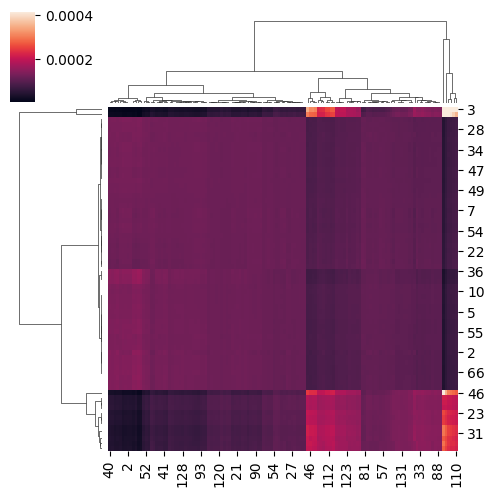

In [21]:
_T = estim_alt.Ts[3][0]
sb.clustermap(_T, figsize = (5, 5), vmax = np.quantile(_T, 0.999))

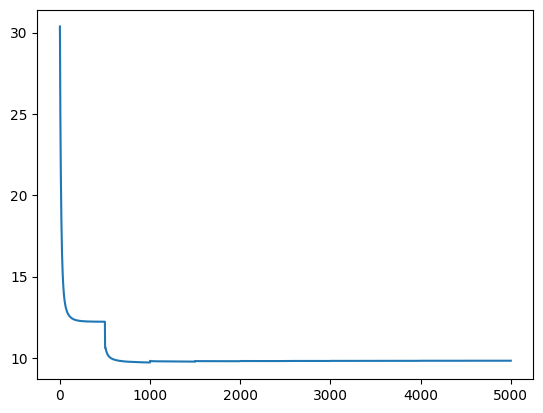

In [22]:
plt.plot(estim_alt.trace)
# plt.plot(estim_wt.trace)

In [24]:
A_renge = pd.read_csv("../data/Renge/A_renge_output.csv", index_col=0)

/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


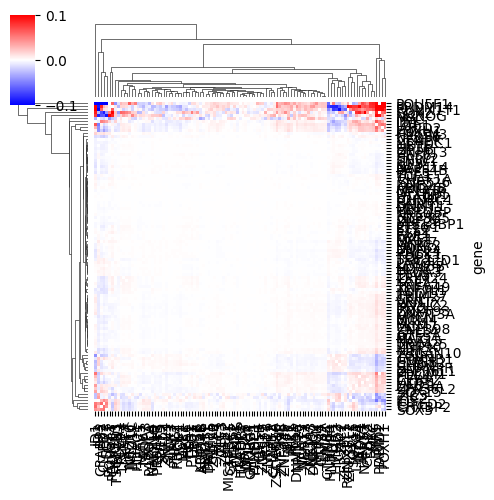

In [25]:
cg = sb.clustermap(A_renge, cmap = "bwr", vmin = -0.1, vmax = 0.1, figsize = (5, 5), xticklabels = 1, yticklabels = 1)
row_idx = A_renge.index[cg.dendrogram_row.reordered_ind]
col_idx = A_renge.columns[cg.dendrogram_col.reordered_ind]


/home/syz/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/syz/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


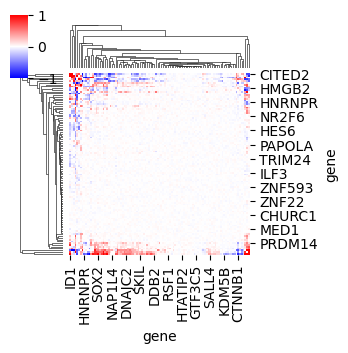

In [409]:
sb.clustermap(pd.DataFrame(estim_alt.A, index = adata_tf.var.index, columns=adata_tf.var.index), 
              vmin = -1, vmax = 1, cmap = "bwr", row_cluster=True, col_cluster=True, figsize = (PLT_CELL, PLT_CELL))
plt.savefig("../figures/scCRISPR_net.pdf")

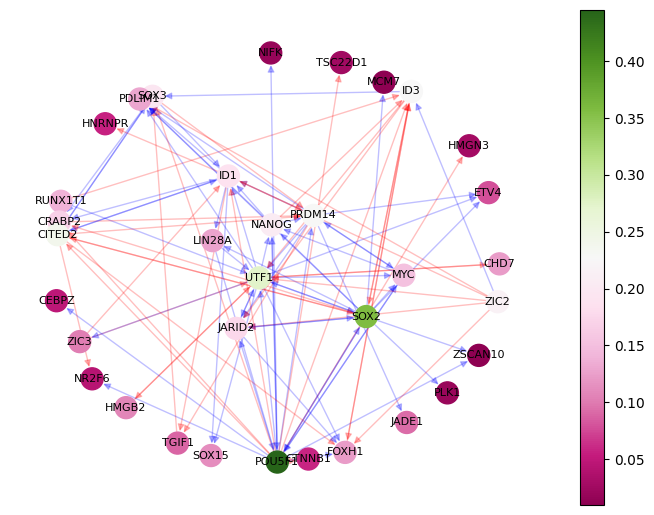

In [26]:
A = pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adata_tf.var.index, columns = adata_tf.var.index)
import networkx as nx

g = nx.DiGraph(np.abs(A))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding

thresh = np.quantile(np.abs(A.values), 0.99)
A[np.abs(A) <= thresh] = 0
g = nx.DiGraph(A)
g = nx.subgraph(g, max(nx.connected_components(nx.Graph(g)), key=len))

edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]

np.random.seed(42)
# nx.draw_nodes(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 250, font_size = 8, cmap = "PiYG", pos=nx.shell_layout(g),)
pos = nx.spring_layout(g, iterations=250, k = 5)
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
pc = nx.draw_networkx_nodes(g, node_color = [centralities[x] for x in g.nodes], node_size = 250, cmap = "PiYG", pos=pos)
plt.colorbar(pc)
nx.draw_networkx_labels(g, pos=pos, font_size=8);
nx.draw_networkx_edges(g, edge_color=edge_colors, pos = pos, alpha = 0.25);
plt.axis("off")
plt.tight_layout()
plt.savefig("./scCRISPR_net_graph.pdf")

/tmp/ipykernel_2140538/18864677.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);


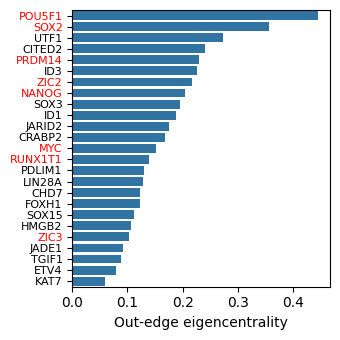

In [28]:
A = pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adata_tf.var.index, columns = adata_tf.var.index)
g = nx.DiGraph(np.abs(A))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding
_centralities = pd.Series(centralities)
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.barplot(_centralities.sort_values()[::-1][:25], orient = 'h')
plt.yticks(fontsize=8);
ax = plt.gca()
y_ticks = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    if label.get_text() in _kos:
        label.set_color('red')
ax.set_yticklabels(y_tick_labels);
plt.xlabel("Out-edge eigencentrality")
plt.tight_layout()
plt.savefig("./scCRISPR_centrality.pdf")

/tmp/ipykernel_2140538/1483940752.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);


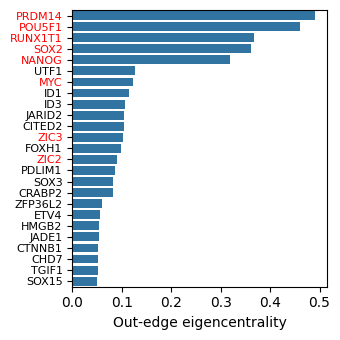

In [30]:
g = nx.DiGraph(np.abs(A_renge.copy()))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding
_centralities = pd.Series(centralities)
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.barplot(_centralities.sort_values()[::-1][:25], orient = 'h')
plt.yticks(fontsize=8);
ax = plt.gca()
y_ticks = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    if label.get_text() in _kos:
        label.set_color('red')
ax.set_yticklabels(y_tick_labels);
plt.xlabel("Out-edge eigencentrality")
plt.tight_layout()
plt.savefig("./scCRISPR_centrality_renge.pdf")

In [46]:
import glob
# Construct reference 
refs = {}
for f in glob.glob("../data/Renge/chip_1kb/*.tsv"):
    gene = os.path.splitext(os.path.basename(f))[0].split(".")[0]
    df = pd.read_csv(f, sep = "\t")
    df.index = df.Target_genes
    # if len(df.columns[df.columns.str.contains("iPS_cells|ES_cells")]) == 0:
    #     print(pd.unique(df.columns.str.split("|").str[1]))
    y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
    # y = pd.Series(df.iloc[:, 2:].values.mean(-1), index = df.index) 
    # y = pd.Series(df.iloc[:, 1], index = df.index) 
    refs[gene] = y

/tmp/ipykernel_2140538/3603932205.py:10: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2140538/3603932205.py:10: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2140538/3603932205.py:10: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encounte

In [44]:
A_ref = pd.DataFrame(refs).T
A_ref[np.isnan(A_ref.values)] = 0

In [48]:
A_ref

Target_genes,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADAC,AADACL2,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
UBTF,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
MED1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
KDM5B,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
MYC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
NR5A2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
PRDM14,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
NANOG,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TCF7L1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TCF3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CHD7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [71]:
A = pd.read_csv('../data/Renge/W_v_seed5_0.0793.csv', header=0, index_col=0)
print(A.head())

A = A.copy()
np.fill_diagonal(A.values, 0)
print(A.index)

        TARDBP  HNRNPR    ID3  PNRC2  ZNF593  LIN28A  HDAC1  ZNF326  CRABP2  \
gene                                                                          
TARDBP    4.43    6.05   6.64   5.53    5.96    6.38   5.70    5.47    6.19   
HNRNPR    5.02    7.82   7.49   6.45    5.94    7.68   6.48    6.41    7.09   
ID3       4.24    7.13  10.43   6.33    6.80    7.48   5.92    7.82    7.34   
PNRC2     3.82    5.52   6.55   4.98    5.89    5.95   5.06    5.07    5.45   
ZNF593    2.74    4.91   5.34   4.42    4.55    4.43   4.02    4.08    5.58   

        NR5A2  ...  SALL4  TCF3  CHAF1A  DNMT1  ILF3  NR2F6  ZNF90  ZNF649  \
gene           ...                                                           
TARDBP   4.61  ...   5.14  5.14    5.86   5.58  6.47   5.85   4.84    5.12   
HNRNPR   5.55  ...   5.88  6.35    6.70   7.22  7.36   6.62   5.88    6.11   
ID3      4.44  ...   6.40  5.04    7.02   6.83  7.85   6.55   4.72    5.49   
PNRC2    3.22  ...   4.79  4.67    5.75   5.63  6.47   4

In [56]:
genes_common = pd.Index(set(A_ref.columns).intersection(set(A.index)))
tfs = A_ref.index
tfs_no_ko = [i for i in tfs if i not in _kos]
tfs_ko = [i for i in tfs if i in _kos]

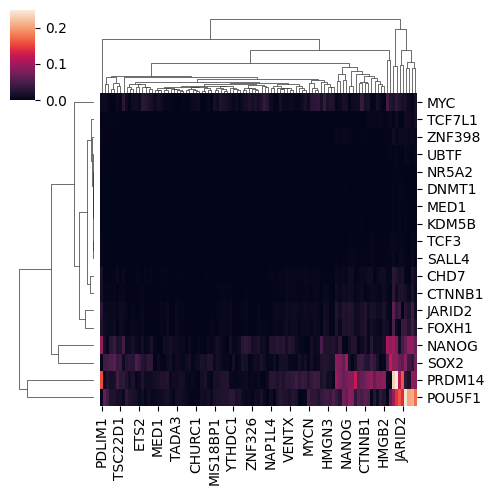

In [57]:
cg = sb.clustermap(A_renge.loc[tfs, genes_common].abs(), figsize = (5, 5))

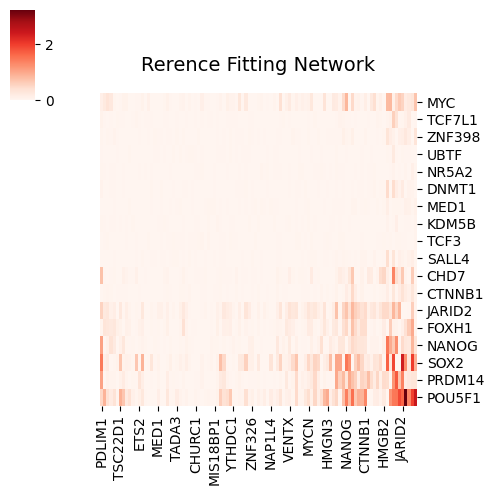

In [51]:
_A = pd.DataFrame(estim_alt.A, index = adata_tf.var.index, columns=adata_tf.var.index)
threshold = np.quantile(_A.values, 0)
_A[_A < threshold] = 0
cg = sb.clustermap(_A.loc[tfs, genes_common].abs().iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), row_cluster = False, cmap="Reds", col_cluster= False)
cg.ax_heatmap.set_title("Rerence Fitting Network", fontsize=14, pad=16)
plt.savefig("RF_heatmap.pdf")

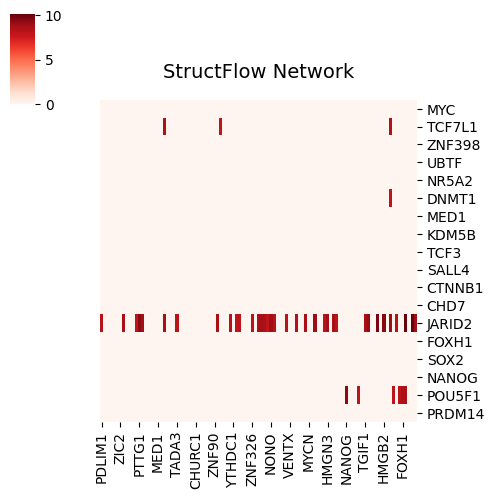

In [165]:
threshold = np.quantile(A.values, 0.99)
A[A < threshold] = 0
cg = sb.clustermap(A.loc[tfs, genes_common].abs().iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), row_cluster = False, cmap="Reds", col_cluster= False)
cg.ax_heatmap.set_title("StructFlow Network", fontsize=14, pad=16)

plt.savefig("structflow_clustermap_reds_thresh.pdf", dpi=300, bbox_inches="tight")
plt.show()

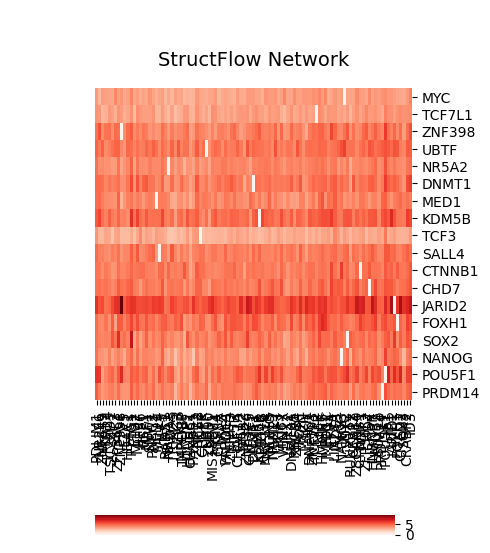

In [70]:
cg = sb.clustermap(
    A.loc[tfs, genes_common].abs().iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind],
    figsize=(5, 5),
    row_cluster=False,
    col_cluster=False,
    cmap="Reds",  # change to Reds
    cbar_pos=(0.2, -0.08, 0.6, 0.04),  # move colorbar below, tweak as needed
    xticklabels=1,
    yticklabels=1,
)

# Add a title ONLY to the heatmap axis:
cg.ax_heatmap.set_title("StructFlow Network", fontsize=14, pad=16)

plt.savefig("structflow_clustermap_reds_belowcbar.pdf", dpi=300, bbox_inches="tight")
plt.show()

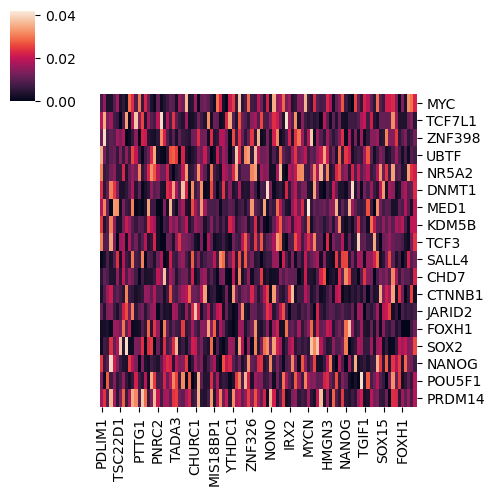

In [419]:
sb.clustermap(_A_wt.loc[tfs, genes_common].abs().iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), row_cluster = False, col_cluster= False)

In [53]:
_tfs = tfs
_thresh = 0

In [65]:
selected_genes = ['MYC', 'TCF7L1', 'ZNF398', 'UBTF', 'NR5A2', 'DNMT1', 'MED1', 'KDM5B', 'TCF3', 'SALL4', 'CHD7', 'CTNNB1', 'JARID2', 'FOXH1', 'NANOG', 
                  'SOX2', 'PRDM14', 'POU5F1'
                ]

In [64]:
genes_in_matrix = set(A_ref.index) & set(A_ref.columns)  # If it's a square matrix

# Filter your selected_genes to only those present
selected_genes_in_matrix = [g for g in selected_genes if g in genes_in_matrix]

print(selected_genes_in_matrix)

['MYC', 'TCF7L1', 'ZNF398', 'UBTF', 'NR5A2', 'DNMT1', 'MED1', 'KDM5B', 'TCF3', 'SALL4', 'CHD7', 'CTNNB1', 'JARID2', 'FOXH1', 'NANOG', 'SOX2', 'PRDM14', 'POU5F1']


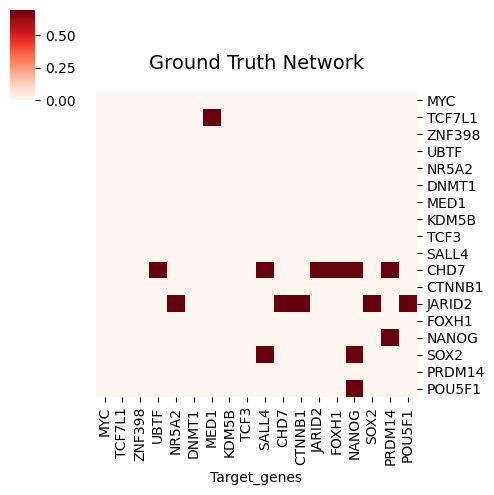

In [68]:
A_ground_truth = A_ref.loc[selected_genes, selected_genes]

A_plot = np.log1p(A_ground_truth > _thresh)  

reference = sb.clustermap(
    A_plot,
    figsize=(5, 5),
    cmap="Reds",
    row_cluster=False,
    col_cluster=False
)
reference.ax_heatmap.set_title("Ground Truth Network", fontsize=14, pad=16)
plt.show()

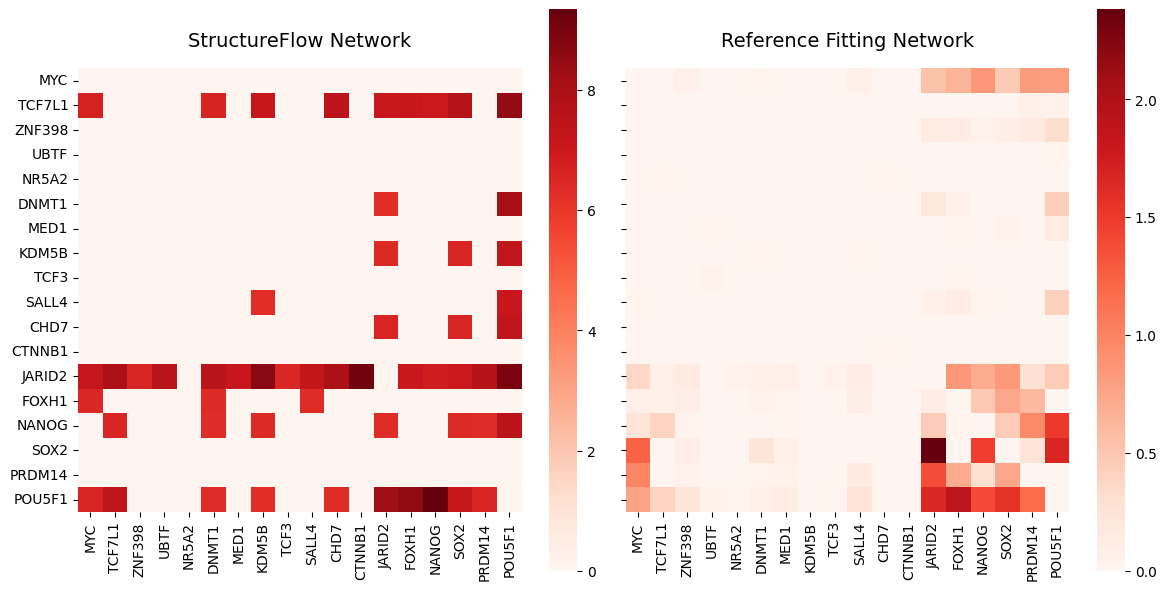

In [78]:
A = pd.read_csv('../data/Renge/W_v_seed5_0.0793.csv', header=0, index_col=0)
A = A.copy()
np.fill_diagonal(A.values, 0)
A_selected = A.loc[selected_genes_in_matrix, selected_genes_in_matrix]
threshold_A = np.quantile(A.values, 0.85)
A_selected = A_selected.where(A_selected >= threshold_A, 0)

# Reference fitting: _A
# (Assuming _A is already created, and is a DataFrame with the same indices/columns)
_A_selected = _A.loc[selected_genes_in_matrix, selected_genes_in_matrix]
threshold__A = np.quantile(_A.values, 0.85)
_A_selected = _A_selected.where(_A_selected >= threshold__A, 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot StructureFlow (A)
sb.heatmap(
    A_selected.abs(),
    ax=axes[0],
    cmap="Reds",
    cbar=True,
    square=True,
    xticklabels=True,
    yticklabels=True
)
axes[0].set_title("StructureFlow Network", fontsize=14, pad=16)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Plot Reference Fitting (_A)
sb.heatmap(
    _A_selected.abs(),
    ax=axes[1],
    cmap="Reds",
    cbar=True,
    square=True,
    xticklabels=True,
    yticklabels=True
)
axes[1].set_title("Reference Fitting Network", fontsize=14, pad=16)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig("StructureFlow_vs_ReferenceFitting.pdf", bbox_inches='tight')
plt.show()

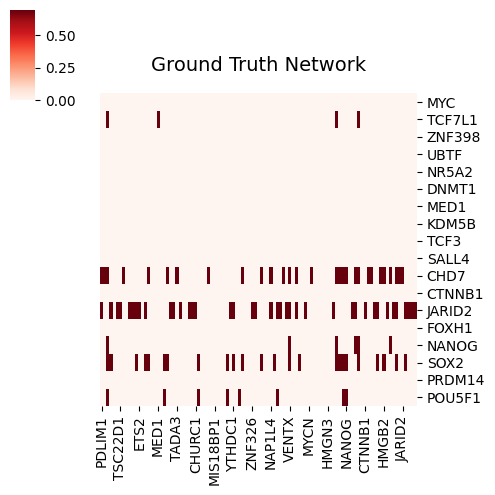

In [67]:
reference = sb.clustermap(np.log1p(A_ref > _thresh).loc[tfs, genes_common].iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], figsize = (5, 5), cmap="Reds", row_cluster = False, col_cluster= False)
reference.ax_heatmap.set_title("Ground Truth Network", fontsize=14, pad=16)

plt.savefig("GroundTruthNetwork.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [63]:
genes_common

Index(['ILF3', 'HNRNPR', 'ZSCAN10', 'SOX15', 'MKI67', 'TARDBP', 'HMGN3',
       'YTHDC1', 'TRIM27', 'CHD7',
       ...
       'PRDM14', 'LIN28A', 'ARID4B', 'SOX2', 'ETV5', 'CHAF1A', 'JMJD1C',
       'MAF1', 'TRIM24', 'JARID2'],
      dtype='object', length=101)

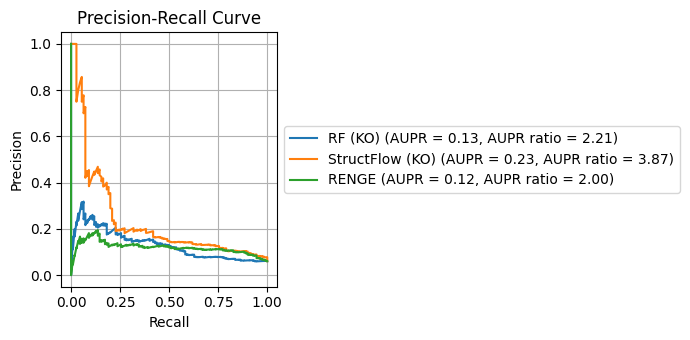

In [160]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = (A_ref.loc[_tfs, genes_common] > _thresh).values.flatten()
ys["RF (KO)"] = np.abs(_A.loc[_tfs, genes_common]).values.flatten()
ys["StructFlow (KO)"] = np.abs(A.loc[_tfs, genes_common]).values.flatten()
ys["RENGE"] = np.abs(A_renge.loc[_tfs, genes_common]).values.flatten()

plt.figure(figsize = (2*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AUPR = {avg_prec:.2f}, AUPR ratio = {avg_prec / y_true.mean():.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig("scCRISPR_AUPR.pdf")